In [25]:
# Column key	Description	Note
# province	Province where data recorded	dd/mm/yyyy
# max	Max tempeture of the day	Celcius
# min	Min tempeture of the day	Celcius
# wind	Wind speed (mod)	km/h
# wind_d	Wind Direction	
# rain	Amount of rain	mm
# humidi	Humidity	%
# cloud	Cloud	%
# pressure		Bar
# date	Date record	yyyy-mm-dd

# https://www.kaggle.com/datasets/vanviethieuanh/vietnam-weather-data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
# Thực hiện lấy dữ liệu từ file csv
df = pd.read_csv("dataset\\weather\\weather.csv")
df['province'].unique()



array(['Bac Lieu', 'Ho Chi Minh City', 'Tam Ky', 'Ben Tre', 'Hoa Binh',
       'Tan An', 'Bien Hoa', 'Hong Gai', 'Thai Nguyen', 'Buon Me Thuot',
       'Hue', 'Thanh Hoa', 'Ca Mau', 'Long Xuyen', 'Tra Vinh', 'Cam Pha',
       'My Tho', 'Tuy Hoa', 'Cam Ranh', 'Nam Dinh', 'Uong Bi', 'Can Tho',
       'Nha Trang', 'Viet Tri', 'Chau Doc', 'Phan Rang', 'Vinh', 'Da Lat',
       'Phan Thiet', 'Vinh Long', 'Ha Noi', 'Play Cu', 'Vung Tau',
       'Hai Duong', 'Qui Nhon', 'Yen Bai', 'Hai Phong', 'Rach Gia',
       'Hanoi', 'Soc Trang'], dtype=object)

In [26]:
corr_col = df.columns[~df.columns.isin(['province', 'date', 'wind_d'])]
df[corr_col].corr()

,max,min,wind,rain,humidi,cloud,pressure
max,1.000000,0.780044,-0.045712,-0.072070,-0.357601,-0.550910,-0.665067
min,0.780044,1.000000,0.184860,0.091397,-0.063603,-0.301693,-0.724969
wind,-0.045712,0.184860,1.000000,0.015043,-0.090157,-0.008016,0.023507
rain,-0.072070,0.091397,0.015043,1.000000,0.360097,0.299645,-0.210100
humidi,-0.357601,-0.063603,-0.090157,0.360097,1.000000,0.546218,-0.153943
cloud,-0.550910,-0.301693,-0.008016,0.299645,0.546218,1.000000,0.175691
pressure,-0.665067,-0.724969,0.023507,-0.210100,-0.153943,0.175691,1.000000


In [27]:
# Tiền xử lý dữ liệu
selected_province = 'Hanoi'
df = df[df['province'] == selected_province]
df['date'] = pd.to_datetime(df['date'])
# df['diff_humidi'] = df['humidi'] - df['humidi'].shift(-1, axis=0)
# df['diff_max_temp'] = df['max'] - df['max'].shift(-1, axis=0)
# df['diff_min_temp'] = df['min'] - df['min'].shift(-1, axis=0)

# Thực hiện sắp xếp theo ngày tăng dần
df = df.set_index('date')
df = df.sort_index()
# Lấy thông tin về lượng mưa ở hàng ngay sau làm giá trị dự đoán lượng mưa ngày hôm sau tại bản ghi hiện tại
df['rain_tomorrow'] = df['rain'].shift(-1, axis=0)
# Loại bỏ hàng cuối cùng do khi thực hiện chuyển dịch thì hàng cuối với cột rain_tomorrow sẽ không có giá trị.
df = df.dropna()



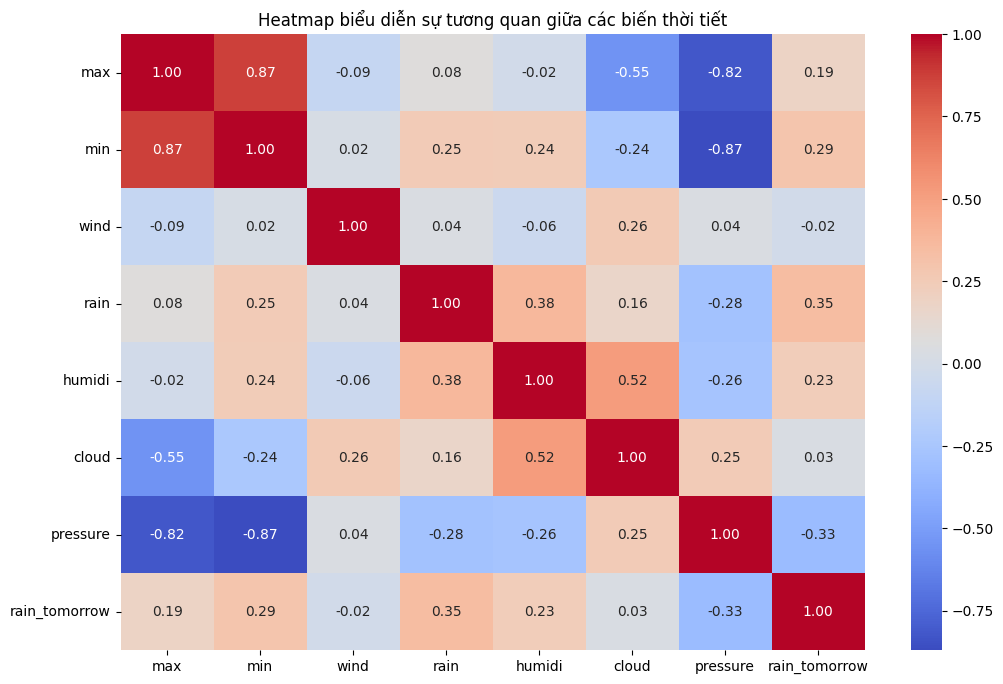

In [28]:
# Khám phá dữ liệu
#ve ban do nhiet
corr_col = df.columns[~df.columns.isin(['province', 'date', 'wind_d'])]  
plt.figure(figsize=(12, 8))
correlation_matrix = df[corr_col].corr() 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap biểu diễn sự tương quan giữa các biến thời tiết")
plt.show()

In [29]:
# Train model
# Lấy các cột feature (tức các cột được sử dụng để cung cấp như đầu vào của mô hình)
# Cụ thể ở đây lấy các cột ngoại trừ province, date, wind_d, rain_tomorrow
feat_col = df.columns[~df.columns.isin(['province', 'date', 'wind_d', 'rain_tomorrow'])]

# Lấy cột target (tức cột cung cấp cho mô hình như kết quả với các đầu vào feature bên trên)
target_col = 'rain_tomorrow'

X = df[feat_col] # Phần dữ liệu đầu vào với các cột feature.
Y = df[target_col] # Phần dữ liệu đầu ra với cột target ứng với cột feature.
# Chia bộ dữ liệu thành 2 phần, 1 phần dùng để train (X_train, y_train) và 1 phần dùng để kiểm thử (X_val, y_val)

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=100)

# Sử dụng mô hình hồi quy tuyến tính.
linear_model = LinearRegression()
# Thực hiện huấn luyện mô hình
linear_model.fit(X_train, y_train)


LinearRegression()

In [30]:
# Test and validate
# Thực hiện sử dụng model tính toán với đầu vào là X_val, lưu kết quả vào bảng res
res = pd.DataFrame(linear_model.predict(X_val), columns=['model'])
# Thực hiện lưu kết quả có sẵn trong bộ kiểm thử vào bảng res
res['validate'] = y_val.values
# Tính độ chênh lệch trong bảng res
res['delta'] = (res['model'] - res['validate']).abs()


print(res)
print(df['rain_tomorrow'].describe())
print("Trung binh sai so: " + str( res['delta'].abs().mean()))
print("Do chenh lech lon nhat: " + str(res['delta'].abs().max()))
print("Do chenh lech nho nhat: " + str(res['delta'].abs().min())) 
print("Do chuan xac: " + str(linear_model.score(X_val, y_val)))
# print(linear_model.score(X_val, y_val))


        model  validate      delta
0    1.337603       0.5   0.837603
1    0.830871       0.1   0.730871
2    2.188258       6.9   4.711742
3    1.578020       0.0   1.578020
4    5.034726       0.4   4.634726
..        ...       ...        ...
905  4.097429       0.3   3.797429
906  5.804768       2.2   3.604768
907  5.106825      27.5  22.393175
908  8.024608       2.4   5.624608
909  5.565848      10.2   4.634152

[910 rows x 3 columns]
count    4548.000000
mean        4.177946
std         8.932186
min         0.000000
25%         0.000000
50%         0.900000
75%         4.525000
max       203.200000
Name: rain_tomorrow, dtype: float64
Trung binh sai so: 4.383275617060983
Do chenh lech lon nhat: 124.1758322021401
Do chenh lech nho nhat: 0.00021168190071418902
Do chuan xac: 0.16724754010685638
